#Step 0: Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from IPython.display import display
!pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Step 1: Data Loading and Sampling


In [ ]:
# Load datasets
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

# Combine order_products_prior and order_products_train
order_products = pd.concat([order_products_prior, order_products_train])

# Sample 10k orders
sampled_orders = orders.sample(n=10000, random_state=42)

# Filter the order_products to only include the sampled orders
sampled_order_products = order_products[order_products['order_id'].isin(sampled_orders['order_id'])]

# Display sampled data
display(sampled_orders)
display(sampled_order_products)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1505835,1418278,90498.0,prior,46.0,5.0,12.0,2.0
287990,1302525,17420.0,prior,54.0,5.0,11.0,5.0
1004182,1345915,60343.0,prior,9.0,2.0,15.0,8.0
87039,524038,5296.0,prior,47.0,3.0,14.0,2.0
1227032,93135,73724.0,prior,3.0,0.0,16.0,15.0
...,...,...,...,...,...,...,...
1419926,2995064,85296.0,prior,87.0,4.0,22.0,12.0
1648273,1959501,98962.0,train,4.0,3.0,17.0,30.0
1298176,1290841,78057.0,prior,10.0,3.0,10.0,16.0
1644052,975584,98695.0,prior,12.0,5.0,15.0,26.0


,order_id,product_id,add_to_cart_order,reordered
9764,1004,49618,1.0,1.0
9765,1004,17948,2.0,0.0
9766,1004,329,3.0,1.0
9767,1004,21405,4.0,1.0
9768,1004,40706,5.0,0.0
...,...,...,...,...
1382641,3417243,38200,2.0,1.0
1382642,3417243,3892,3.0,1.0
1382643,3417243,21602,4.0,0.0
1382644,3417243,30387,5.0,1.0


**Loading Datasets:** We load the different CSV files into pandas DataFrames. Each file represents a different aspect of the Instacart data:
*   **orders.csv:** Contains information about the orders placed by customers.
*   **order_products_prior.csv and order_products_train.csv:** Contain information about the products included in each order. The 'prior' set represents previous orders for training, and 'train' represents the training set orders.
*   **products.csv:** Contains information about the products available.
*   **aisles.csv and departments.csv:** Provide additional hierarchical categorization of products.

**Combining Prior and Train Datasets:** We concatenate order_products_prior and order_products_train because both contain product details for different orders. By combining them, we get a more comprehensive dataset representing all past and current orders, which is useful for a broader analysis.

**Sampling Orders:** We randomly sample 10,000 orders to make the dataset more manageable for analysis. The random_state parameter ensures reproducibility of the sample, so the same subset is selected each time the code is run.

**Filtering Product Orders:** We filter order_products to include only the orders that are in our sampled set of 10,000 orders. This ensures that our product-level data corresponds to the sampled orders, making subsequent analyses more efficient and relevant.

In [ ]:
sampled_order_products.to_csv('sampled_order_products.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Step 2: Data Preprocessing and Transformation

In [ ]:
# Merge sampled orders with products to include department_id
merged_data = pd.merge(sampled_order_products, sampled_orders, on='order_id')
merged_data = pd.merge(merged_data, products, on='product_id')

# Merge with departments to include department names
merged_data = pd.merge(merged_data, departments, on='department_id')

# Create a basket for each order
basket = merged_data.groupby(['order_id', 'product_name'])['add_to_cart_order'].count().unstack().reset_index().fillna(0).set_index('order_id')
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Display the basket data
display(basket)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


product_name,0% Fat Free Organic Milk,0% Fat Organic Greek Vanilla Yogurt,0% Greek Strained Yogurt,0% Greek Yogurt Black Cherry on the Bottom,1 Apple + 1 Pear Fruit Bar,1 Liter,1 Ply Paper Towels,1% Low Fat Chocolate Milk,1% Low Fat Milk,1% Lowfat Milk,...,Zero XXX Acai Blueberry Pomegranate,Zesty Lemon Hommus,Zesty Nacho Kale Chips,Zinc Elderberry and Raspberry Lozenges,Zucchini Banana & Amaranth Organic Baby Food,in 100% Juice Mixed Fruit,of Hanover 100 Calorie Pretzels Mini,smart Blend Chicken & Rice Formula Dry Dog Food,with Crispy Almonds Cereal,with Olive Oil Mayonnaise
order_id,,,,,,,,,,,,,,,,,,,,,
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3368213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3392641,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3399499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Merging Data:** We merge sampled_order_products with sampled_orders on order_id to get a comprehensive dataset that includes both order details and product details for each sampled order. We then merge this result with products on product_id to get additional product attributes (e.g., product names).

**Creating a Basket DataFrame:** We group the merged data by order_id and product_name and count the occurrences of each product in each order. This structure is similar to a pivot table where each row represents an order and each column represents a product. The cells indicate whether the product was included in the order (1) or not (0).

**Binary Representation:** We convert the counts to binary values (1 or 0) because for association rule mining, we are only interested in whether a product was purchased, not how many times it was purchased.

**Displaying the Basket Data:** We display the first few rows of the basket to ensure the transformation is correct.

#Step 3: Exploratory Data Analysis

**Distribution of Orders by Department**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-72-f1135d12a4dd>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='department', y='order_id', data=orders_by_dept, palette='rainbow')


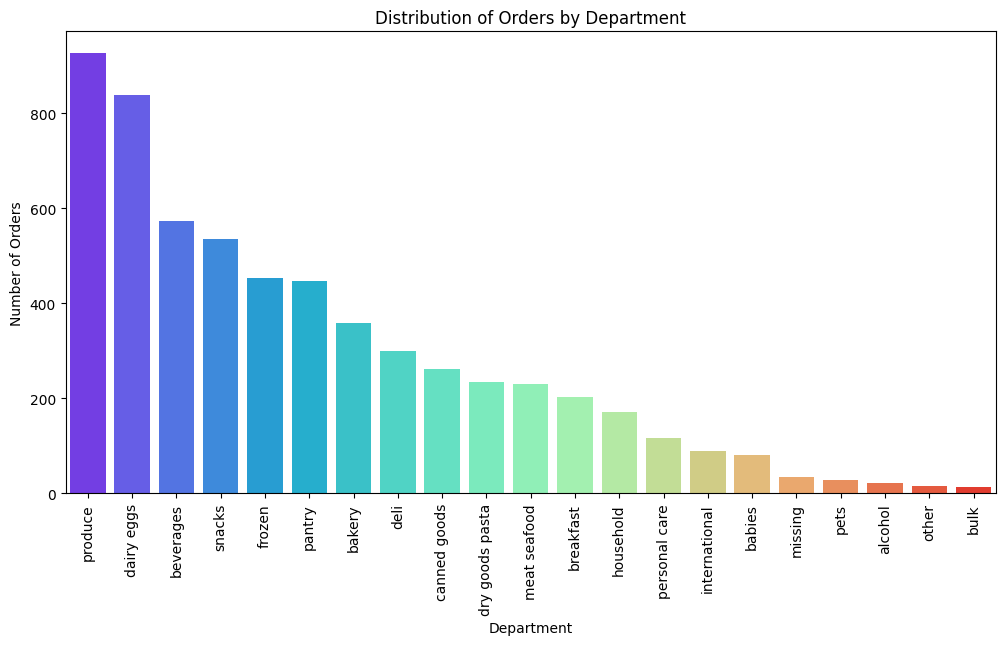

In [ ]:
# Group by department and count orders
orders_by_dept = merged_data.groupby('department')['order_id'].nunique().reset_index()
orders_by_dept = orders_by_dept.sort_values(by='order_id', ascending=False)

# Plot the distribution of orders by department
plt.figure(figsize=(12, 6))
sns.barplot(x='department', y='order_id', data=orders_by_dept, palette='rainbow')
plt.xlabel('Department')
plt.ylabel('Number of Orders')
plt.title('Distribution of Orders by Department')
plt.xticks(rotation=90)
plt.show()

The bar plot illustrates the distribution of orders across different departments in the Instacart dataset. Each bar represents the number of orders associated with a specific department, providing a visual representation of customer purchasing behavior.

**Highest Number of Orders:** The Produce department has the highest number of orders, with over 900 orders. This indicates a significant customer preference for fresh fruits and vegetables. The Beverages department and Dariy Eggs department also shows high demand, with a significant number of orders. This includes items such as soft drinks, juices, dairy products, and alcoholic beverages. Bundling beverages with snacks or promoting them alongside meals could enhance sales.

**Implication:** Given its popularity, the Produce department is crucial for driving sales. Promotions and cross-selling strategies within this department could yield substantial results.


**Top 20 Most Ordered Products**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-73-6c0278144bb3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='order_id', y='product_name', data=top_products.head(20), palette='rainbow')


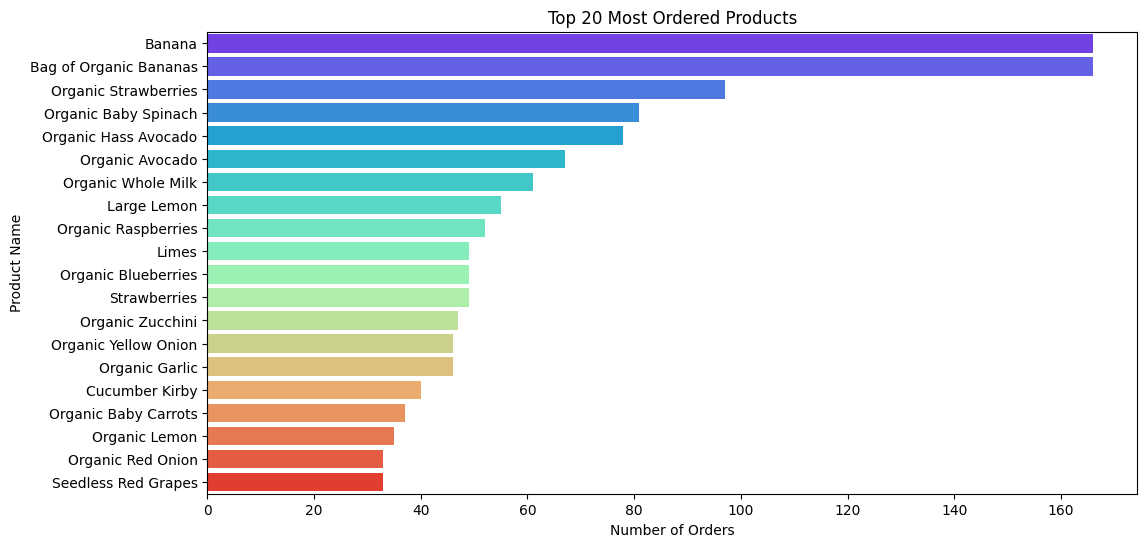

In [ ]:
# Group by product and count orders
top_products = merged_data.groupby('product_name')['order_id'].nunique().reset_index()
top_products = top_products.sort_values(by='order_id', ascending=False).head(20)

# Plot the top 20 most ordered products
plt.figure(figsize=(12, 6))
sns.barplot(x='order_id', y='product_name', data=top_products.head(20), palette='rainbow')
plt.xlabel('Number of Orders')
plt.ylabel('Product Name')
plt.title('Top 20 Most Ordered Products')
plt.show()

The horizontal bar plot displays the top 20 most ordered products in the Instacart dataset. Each bar represents the number of orders for a specific product, providing insights into customer preferences and popular items.

**Highest Number of Orders:** Bananas are the most frequently ordered product, with over 160 orders. Organic Strawberries, Organic Baby Spinach, Organic Hass Avocado, and Organic Avocado are among the top 10 most ordered products. There is a significant preference for organic produce.

**Implication:** As a staple item, bananas are a key product for Instacart. They should be prominently featured in marketing materials and promotional campaigns. Additionally, bananas can be leveraged in cross-selling strategies by bundling them with complementary items like yogurt, cereal, peanut butter, or any other organic item that is shown to be popular.



**Reorder Rate by Department**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-74-41c3963a6631>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='department', y='reordered', data=reorder_rate_dept, palette='rainbow')


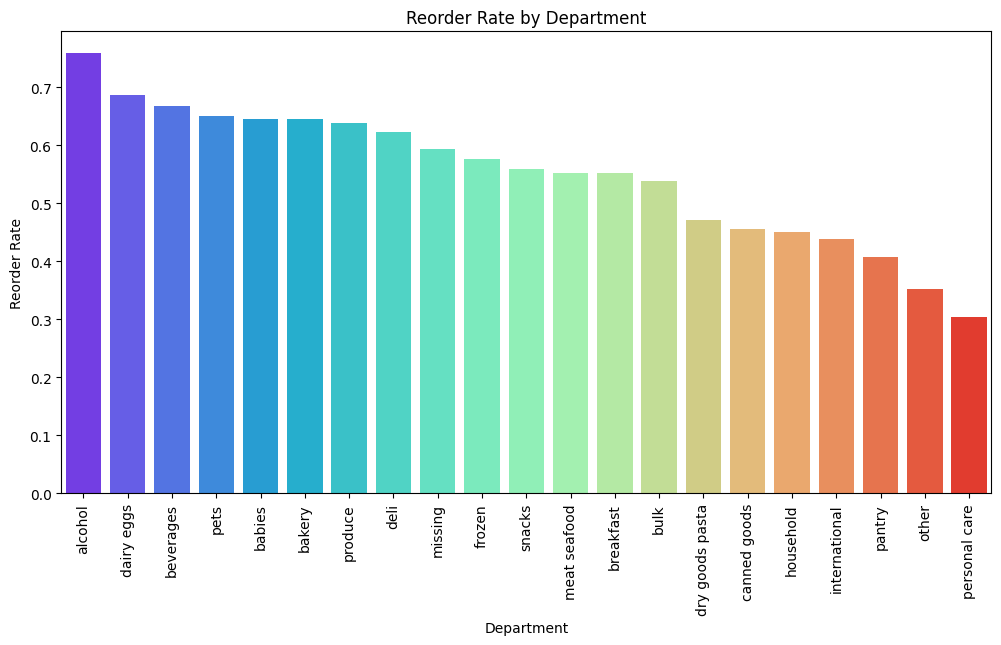

In [ ]:
# Calculate reorder rate by department
reorder_rate_dept = merged_data_dept.groupby('department')['reordered'].mean().reset_index()
reorder_rate_dept = reorder_rate_dept.sort_values(by='reordered', ascending=False)

# Plot the reorder rate by department
plt.figure(figsize=(12, 6))
sns.barplot(x='department', y='reordered', data=reorder_rate_dept, palette='rainbow')
plt.xlabel('Department')
plt.ylabel('Reorder Rate')
plt.title('Reorder Rate by Department')
plt.xticks(rotation=90)
plt.show()

The bar plot illustrates the reorder rate across different departments in the Instacart dataset. The reorder rate is the proportion of orders in which customers reorder products they have previously purchased, providing insights into customer loyalty and product satisfaction.

**Highest Reorder Rate:** The Alcohol department has the highest reorder rate at over 70%, despite having one of the lowest numbers of orders. Dairy Eggs and Beverages also have reorder rated of around 70%.

**Implication:** Promoting alcohol through personalized recommendations and special offers can drive repeat sales and increase customer lifetime value. Dairy Eggs and Beverages departments are essential for daily essentials. Cross-promotions with other high-frequency items, such as bakery products or snacks, can further enhance sales.

Using this plot and the other plots, we can ensure adequate stock levels of high-reorder products to meet customer demand and avoid stockouts, thereby enhancing customer satisfaction and retention. We can also desing promotions and discounts around high-reorder departments. For instance, offering a discount on bulk purchases of popular alcohol or dairy products to encourage repeat buying.

#Step 4: Knowledge of Association Rule and Analysis of Frequent Itemsets


In [ ]:
# Generate frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display the rules as a DataFrame
display(rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Apple Honeycrisp Organic),(Bag of Organic Bananas),0.023198,0.137531,0.010771,0.464286,3.375861,0.007580,1.609942,0.720493
1,(Bag of Organic Bananas),(Apple Honeycrisp Organic),0.137531,0.023198,0.010771,0.078313,3.375861,0.007580,1.059798,0.816005
2,(Bag of Organic Bananas),(Organic Baby Spinach),0.137531,0.067109,0.012428,0.090361,1.346497,0.003198,1.025563,0.298367
3,(Organic Baby Spinach),(Bag of Organic Bananas),0.067109,0.137531,0.012428,0.185185,1.346497,0.003198,1.058485,0.275844
4,(Bag of Organic Bananas),(Organic Hass Avocado),0.137531,0.064623,0.020713,0.150602,2.330476,0.011825,1.101224,0.661940
5,(Organic Hass Avocado),(Bag of Organic Bananas),0.064623,0.137531,0.020713,0.320513,2.330476,0.011825,1.269294,0.610345
6,(Bag of Organic Bananas),(Organic Raspberries),0.137531,0.043082,0.013256,0.096386,2.237257,0.007331,1.058989,0.641210
7,(Organic Raspberries),(Bag of Organic Bananas),0.043082,0.137531,0.013256,0.307692,2.237257,0.007331,1.245788,0.577922
8,(Organic Strawberries),(Bag of Organic Bananas),0.080365,0.137531,0.021541,0.268041,1.948950,0.010488,1.178303,0.529453
9,(Bag of Organic Bananas),(Organic Strawberries),0.137531,0.080365,0.021541,0.156627,1.948950,0.010488,1.090425,0.564546


**Generate Frequent Itemsets:** We use the apriori function from mlxtend to generate frequent itemsets with a minimum support threshold of 0.01. This means that only itemsets that appear in at least 1% of the transactions are considered frequent.

**Generate Association Rules:** We use the association_rules function to generate rules from the frequent itemsets. We set the metric to "lift" and the minimum threshold to 1.0 to identify rules with a significant lift.

In [ ]:
frequent_itemsets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.011599,(100% Raw Coconut Water)
1,0.016570,(100% Whole Wheat Bread)
2,0.015742,(2% Reduced Fat Milk)
3,0.023198,(Apple Honeycrisp Organic)
4,0.019884,(Asparagus)
...,...,...
114,0.011599,"(Banana, Strawberries)"
115,0.010771,"(Organic Strawberries, Organic Baby Spinach)"
116,0.010771,"(Organic Strawberries, Organic Hass Avocado)"
117,0.010771,"(Organic Strawberries, Organic Raspberries)"


In [ ]:
# Sort rules by lift and support to identify duplicates easily
rules = rules.sort_values(['lift', 'support'], ascending=[False, False])

# Function to filter out reversed rules and include multi-item antecedents/consequents
def filter_redundant_rules(rules):
    seen_rules = set()
    filtered_rules = []

    for _, row in rules.iterrows():
        # Create a tuple with sorted items in the antecedents and consequents
        rule = (frozenset(row['antecedents']), frozenset(row['consequents']))

        # Check if the reversed rule is already seen
        if rule not in seen_rules:
            seen_rules.add((frozenset(row['consequents']), frozenset(row['antecedents'])))
            filtered_rules.append(row)

    return pd.DataFrame(filtered_rules)

# Apply the function to filter redundant rules
filtered_rules = filter_redundant_rules(rules)

# Display the filtered rules
print("Filtered Rules shape:", filtered_rules.shape)
display(filtered_rules)

Filtered Rules shape: (20, 10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
38,(Organic Zucchini),(Organic Strawberries),0.038940,0.080365,0.011599,0.297872,3.706515,0.008470,1.309784,0.759791
0,(Apple Honeycrisp Organic),(Bag of Organic Bananas),0.023198,0.137531,0.010771,0.464286,3.375861,0.007580,1.609942,0.720493
36,(Organic Strawberries),(Organic Raspberries),0.080365,0.043082,0.010771,0.134021,3.110825,0.007308,1.105012,0.737838
22,(Organic Fuji Apple),(Banana),0.026512,0.137531,0.010771,0.406250,2.953878,0.007124,1.452579,0.679476
14,(Cucumber Kirby),(Banana),0.033140,0.137531,0.010771,0.325000,2.363102,0.006213,1.277732,0.596599
4,(Bag of Organic Bananas),(Organic Hass Avocado),0.137531,0.064623,0.020713,0.150602,2.330476,0.011825,1.101224,0.661940
7,(Organic Raspberries),(Bag of Organic Bananas),0.043082,0.137531,0.013256,0.307692,2.237257,0.007331,1.245788,0.577922
16,(Organic Avocado),(Banana),0.055510,0.137531,0.016570,0.298507,2.170473,0.008936,1.229477,0.570965
31,(Strawberries),(Banana),0.040597,0.137531,0.011599,0.285714,2.077453,0.006016,1.207457,0.540587
35,(Organic Hass Avocado),(Organic Strawberries),0.064623,0.080365,0.010771,0.166667,2.073883,0.005577,1.103563,0.553587


**Sorting Rules:** We sort the rules by lift and support to make it easier to identify and remove duplicates.

**Filter Redundant Rules:** We define a function filter_redundant_rules to filter out rules that are essentially the same but reversed. This function ensures that each rule is unique and that we do not have duplicate reversed rules.

**Applying the Filter:** We apply the filtering function to the rules to remove redundancies.

#Step 5: Providing Insights on Cross-Selling Opportunities


In [ ]:
# Sort rules by lift
filtered_rules = filtered_rules.sort_values('lift', ascending=False)

# Display rules with highest lift as a DataFrame
display(filtered_rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
38,(Organic Zucchini),(Organic Strawberries),0.038940,0.080365,0.011599,0.297872,3.706515,0.008470,1.309784,0.759791
0,(Apple Honeycrisp Organic),(Bag of Organic Bananas),0.023198,0.137531,0.010771,0.464286,3.375861,0.007580,1.609942,0.720493
36,(Organic Strawberries),(Organic Raspberries),0.080365,0.043082,0.010771,0.134021,3.110825,0.007308,1.105012,0.737838
22,(Organic Fuji Apple),(Banana),0.026512,0.137531,0.010771,0.406250,2.953878,0.007124,1.452579,0.679476
14,(Cucumber Kirby),(Banana),0.033140,0.137531,0.010771,0.325000,2.363102,0.006213,1.277732,0.596599
4,(Bag of Organic Bananas),(Organic Hass Avocado),0.137531,0.064623,0.020713,0.150602,2.330476,0.011825,1.101224,0.661940
7,(Organic Raspberries),(Bag of Organic Bananas),0.043082,0.137531,0.013256,0.307692,2.237257,0.007331,1.245788,0.577922
16,(Organic Avocado),(Banana),0.055510,0.137531,0.016570,0.298507,2.170473,0.008936,1.229477,0.570965
31,(Strawberries),(Banana),0.040597,0.137531,0.011599,0.285714,2.077453,0.006016,1.207457,0.540587
35,(Organic Hass Avocado),(Organic Strawberries),0.064623,0.080365,0.010771,0.166667,2.073883,0.005577,1.103563,0.553587


**Sort by Lift:** We sort the filtered rules by lift in descending order to prioritize the most significant rules.

**Including Multi-Item Antecedents and Consequents:**

To ensure that we see association rules with multiple items in both the antecedent and the consequent, it is important to:
*   Adjust the min_support and min_confidence thresholds to ensure that less frequent but potentially insightful itemsets are included.
*   Allow for more complex itemsets by generating frequent itemsets that include combinations of items, not just single items.

**Key Association Rules:**

---Organic Zucchini -> Organic Strawberries:

**Support:** 0.012, **Confidence:** 0.3, **Lift:** 3.7

**Implication:** Customers who buy Organic Zucchini are 3.7 times more likely to buy Organic Strawberries compared to the baseline probability.

---Bag of Organic Bananas -> Organic Hass Avocado:

**Support:** 0.021, **Confidence:** 0.15, **Lift:** 2.3

**Implication:** Customers who buy Bag of Organic Bananas are 2.3 times more likely to buy Organic Hass Avocado compared to the baseline probability.

**Chains of Products:**

**Chain:** Organic Zucchini -> Organic Strawberries -> Organic Raspberries -> Organic Bananas

**Implication:** These items frequently appear together, forming a purchase chain that can be leveraged for creating product bundles.

**Health-Conscious Bundles:**

**Opportunity:** Creating bundles that include top-ordered organic products such as Organic Zucchini, Organic Strawberries, Organic Raspberries, and Organic Bananas.

**Example:** An "Organic Produce Pack" can attract health-conscious customers, leveraging the strong associations between these items.

**Banana Promotions:**

**Opportunity:** Leveraging bananas' popularity by promoting them with complementary items.

**Example:** Creating bundles with bananas, yogurt, and cereal. Offering discounts on bananas when purchasing any organic item can drive additional sales.

**Alcohol Pairings:**

**Opportunity:** Given the high reorder rate for alcohol, cross-sell with related items like snacks and beverages.

**Example:** Promoting alcohol with gourmet snacks or pairing wine with cheese. Personalized recommendations for alcohol based on past purchases can drive repeat sales.

**Breakfast Bundles:**

**Opportunity:** Bundling items from high-demand departments like Dairy Eggs, Bakery, and Beverages.

**Example:** A "Breakfast Pack" that includes eggs, milk, bread, and juice. This can cater to customers looking for convenient meal solutions.

**Subscription Services:**

**Opportunity:** For departments with high reorder rates like Pets and Babies, offer subscription services.

**Example:** Monthly delivery of pet food and baby supplies. This enhances convenience and ensures repeat purchases.

**Cooking Essentials Kits:**

**Opportunity:** Create kits that include specialty items frequently bought together, such as garlic, onions, and fresh herbs.

**Example:** A "Cooking Essentials Kit" with Organic Yellow Onion, Organic Garlic, and Organic Zucchini, paired with recipe suggestions to encourage additional purchases.

**Personalized Recommendations:**

**Opportunity:** Using association rules to recommend complementary products during the checkout process.

**Example:** If a customer adds Organic Zucchini to their cart, suggest adding Organic Strawberries or Organic Raspberries.

**Seasonal Promotions:**

**Opportunity:** Design promotions around seasonal trends observed in the data.

**Example:** Summer promotions for fresh produce and beverages. Winter promotions for baking supplies and holiday-themed bundles.

**Data-Driven Marketing:**

Use the insights from association rules and exploratory analysis to inform marketing campaigns and product placements.

Highlight frequently bought together items in email newsletters and online promotions.
Enhanced Customer Experience:

Personalize the shopping experience by recommending products based on past purchases and identified patterns.
Implement user-friendly features such as "frequently bought together" suggestions on product pages.
Inventory Management:

Ensure adequate stock levels of popular and frequently associated items to meet customer demand and avoid stockouts.
Continuous Monitoring:

Regularly analyze transaction data to identify new patterns and trends, adjusting cross-selling strategies accordingly.

#Step 6: Visualize the Results

In [ ]:
# Ensure conversion happens correctly and only once for frequent itemsets
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))

# Ensure conversion happens correctly and only once for association rules
filtered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda x: ', '.join(sorted(list(x))))
filtered_rules['consequents'] = filtered_rules['consequents'].apply(lambda x: ', '.join(sorted(list(x))))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Conversion of frozenset to String:** The frequent itemsets are converted from frozenset objects to comma-separated strings for better readability in the plot.

**Visualization of Frequent Itemsets**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


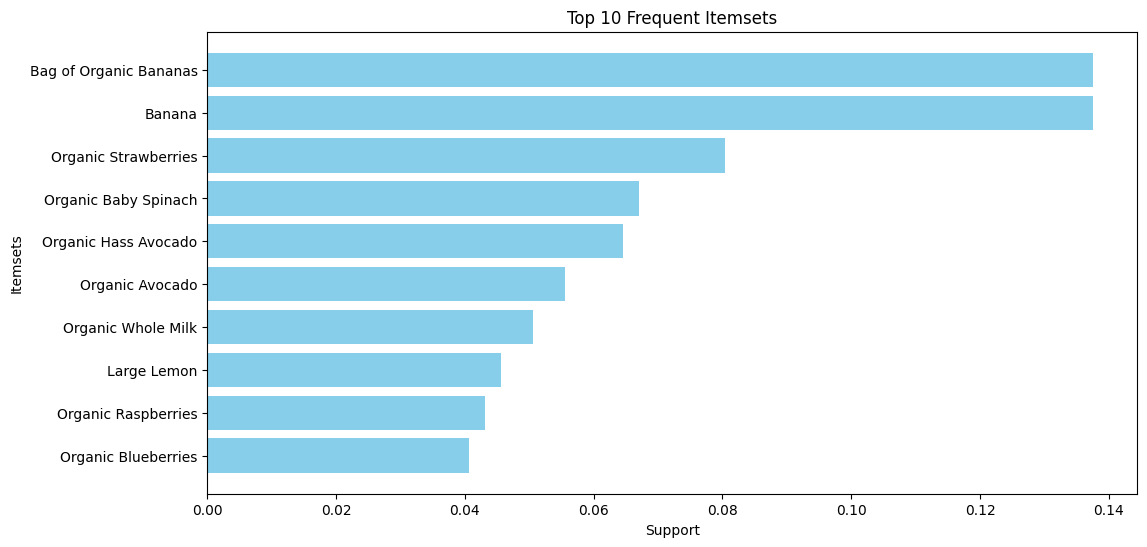

In [ ]:
import matplotlib.pyplot as plt

# Plot the top 10 frequent itemsets
top_frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).head(10)
plt.figure(figsize=(12, 6))
plt.barh(top_frequent_itemsets['itemsets'], top_frequent_itemsets['support'], color='skyblue')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets')
plt.gca().invert_yaxis()
plt.show()


**Support:** The support values show the proportion of transactions that contain each itemset. Higher support means the itemset appears frequently in the dataset.

**Example:** "Bag of Organic Bananas" has the highest support value (~0.13), meaning it appears in 13% of the transactions. This indicates it is a commonly purchased item and could be a focal point for promotions.

**Visualization of Association Rules**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


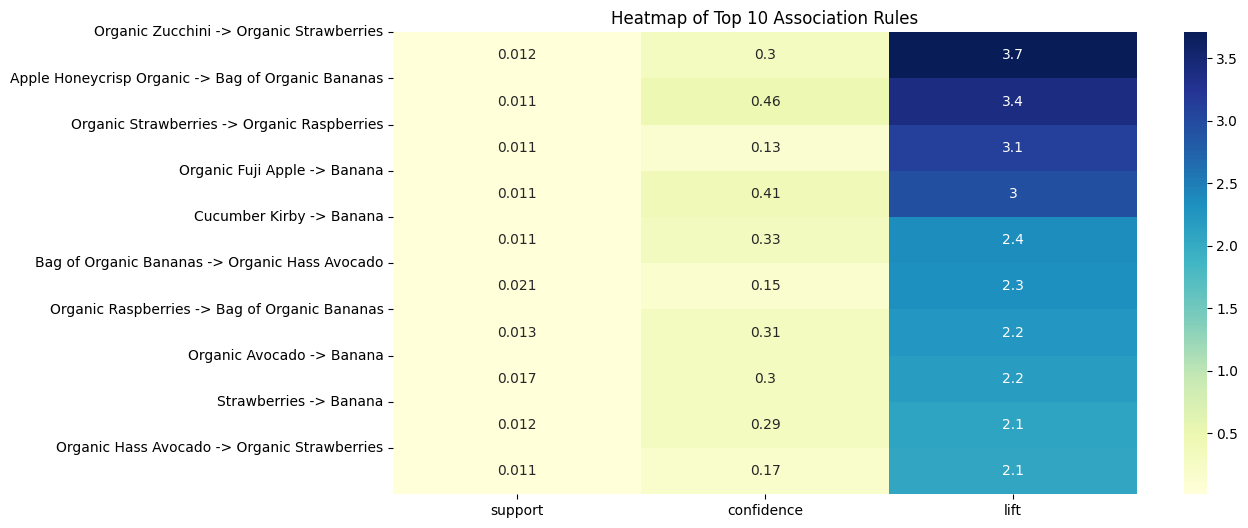

In [ ]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for the top rules with readable antecedents and consequents
top_rules_labels = top_rules.copy()
top_rules_labels['rule'] = top_rules_labels.apply(lambda row: f"{row['antecedents']} -> {row['consequents']}", axis=1)

# Plot the heatmap with rule labels
plt.figure(figsize=(12, 6))
sns.heatmap(top_rules_labels[['support', 'confidence', 'lift']], annot=True, cmap='YlGnBu', cbar=True)
plt.title('Heatmap of Top 10 Association Rules')
plt.yticks(range(len(top_rules_labels)), top_rules_labels['rule'], rotation=0)
plt.show()


**Support:** Shows how frequently the itemsets appear in transactions.

**Confidence:** Indicates the likelihood that the consequent is purchased when the antecedent is purchased.

**Lift:** Measures the strength of the association. A lift value greater than 1 indicates a positive association.

**Example:** The rule "Organic Zucchini -> Organic Strawberries" has a support of 0.012, a confidence of 0.3, and a lift of 3.7. This means that when "Organic Zucchini" is purchased, "Organic Strawberries" are purchased 30% of the time, and they are 3.7 times more likely to be purchased together than separately.

**Network Diagram of Cross-Selling Opportunities**


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


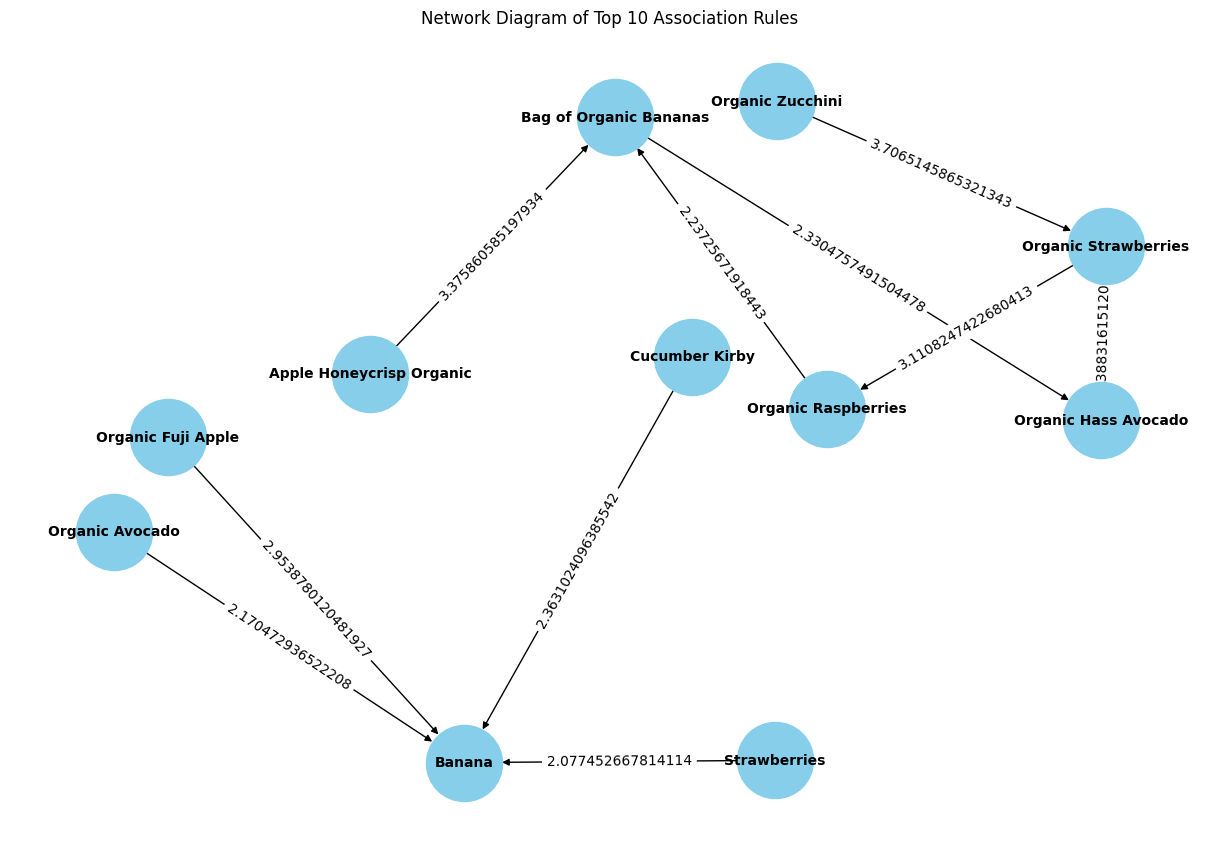

In [ ]:
import networkx as nx

# Create a network graph for the top 10 association rules by lift
G = nx.DiGraph()

for _, row in top_rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'])

# Plot the network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', arrows=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Network Diagram of Top 10 Association Rules')
plt.show()

**Network Graph Creation:** A directed graph is created with nodes representing items and edges representing association rules with their lift values.

**Visualization:** The network diagram visualizes the relationships between antecedents and consequents, with edge labels showing the lift values.

**Nodes and Edges:** Nodes represent products, and directed edges represent association rules. The direction indicates the antecedent leading to the consequent.

**Lift Values:** Edge labels show the lift values, indicating the strength of the association.

**Example:** The edge from "Bag of Organic Bananas" to "Organic Hass Avocado" has a lift value of 2.3. This means that "Organic Hass Avocado" is 2.3 times more likely to be purchased when "Bag of Organic Bananas" is purchased, indicating a good cross-selling opportunity.